# Neural Network Training Dynamics: Example Learning and Feature Discovery - Enhanced Version

This notebook implements techniques from "Outliers with Opposing Signals Have an Outsized Effect on Neural Network Optimization" and other related works to analyze:
- Which examples are being learned during training
- Feature learning dynamics in CNNs
- Detection of opposing signals and their effects
- Individual example forgetting patterns
- **ENHANCED: Time-based clustering of learning patterns**
- **ENHANCED: Class-wise analysis and difficulty tracking**
- **ENHANCED: Example difficulty progression over time**

**Key papers implemented:**
- Rosenfeld & Risteski (2023): Outliers with Opposing Signals
- Toneva et al. (2019): An Empirical Study of Example Forgetting
- Various feature visualization techniques

In [ ]:
DATA_PATH = 'C:\\Users\\mateu\\phd\\data'  # Change this to your desired data path

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
import torchvision
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import time
import warnings
warnings.filterwarnings("ignore")

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## 1. Data Loading and Preprocessing

In [ ]:
# Data transforms
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

# Load datasets
trainset = torchvision.datasets.CIFAR10(root=DATA_PATH, train=True, download=True, transform=transform_train)
testset = torchvision.datasets.CIFAR10(root=DATA_PATH, train=False, download=True, transform=transform_test)

# Use a subset for faster experimentation (optional)
SUBSET_SIZE = 10000  # Set to None to use full dataset
if SUBSET_SIZE is not None:
    indices = torch.randperm(len(trainset))[:SUBSET_SIZE]
    trainset_subset = Subset(trainset, indices)
    # Store original labels for class analysis
    subset_labels = [trainset[i][1] for i in indices]
else:
    trainset_subset = trainset
    subset_labels = [trainset[i][1] for i in range(len(trainset))]

trainloader = DataLoader(trainset_subset, batch_size=128, shuffle=False, num_workers=2)
testloader = DataLoader(testset, batch_size=128, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

print(f"Training samples: {len(trainset_subset)}")
print(f"Test samples: {len(testset)}")
print(f"Classes: {classes}")

Files already downloaded and verified
Files already downloaded and verified
Training samples: 10000
Test samples: 10000
Classes: ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


## 2. Model Architectures

In [3]:
class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
    
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class SmallResNet(nn.Module):
    def __init__(self, num_classes=10):
        super(SmallResNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        
        self.layer1 = self._make_layer(BasicBlock, 32, 32, 2, stride=1)
        self.layer2 = self._make_layer(BasicBlock, 32, 64, 2, stride=2)
        self.layer3 = self._make_layer(BasicBlock, 64, 128, 2, stride=2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(128, num_classes)
        
        # For feature extraction
        self.features = []
        self.register_hooks()
    
    def _make_layer(self, block, in_channels, out_channels, blocks, stride):
        layers = []
        layers.append(block(in_channels, out_channels, stride))
        for _ in range(1, blocks):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)
    
    def register_hooks(self):
        def hook_fn(module, input, output):
            self.features.append(output.detach().cpu())
        
        self.layer1.register_forward_hook(hook_fn)
        self.layer2.register_forward_hook(hook_fn)
        self.layer3.register_forward_hook(hook_fn)
    
    def forward(self, x):
        self.features = []  # Clear previous features
        
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        
        out = self.avgpool(out)
        out = torch.flatten(out, 1)
        out = self.fc(out)
        
        return out

# Initialize model
model = SmallResNet().to(device)
print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

Model parameters: 696,618


## 3. Enhanced Example Tracking System

This enhanced system includes time-based clustering and class-wise analysis.

In [4]:
class EnhancedExampleTracker:
    def __init__(self, dataset_size, class_labels):
        self.dataset_size = dataset_size
        self.class_labels = class_labels  # Store class labels for each example
        self.example_losses = defaultdict(list)
        self.example_predictions = defaultdict(list)
        self.example_correctness = defaultdict(list)
        self.example_gradients = defaultdict(list)
        self.example_features = defaultdict(list)
        self.forgetting_events = defaultdict(int)
        self.learning_events = defaultdict(int)
        self.opposing_signals = []
        
        # Enhanced tracking for time-based analysis
        self.epoch_stats = []  # Store stats for each epoch
        self.class_stats = defaultdict(lambda: defaultdict(list))  # Per-class tracking
        self.difficulty_timeline = []  # Track example difficulty over time
        
    def update(self, epoch, example_ids, losses, predictions, targets, gradients=None, features=None):
        """Enhanced update with class-wise and temporal tracking"""
        epoch_losses = []
        epoch_correctness = []
        class_performance = defaultdict(lambda: {'correct': 0, 'total': 0, 'losses': []})
        
        for i, example_id in enumerate(example_ids):
            loss = losses[i].item()
            pred = predictions[i].item()
            target = targets[i].item()
            correct = (pred == target)
            
            # Get class label for this example
            class_label = self.class_labels[example_id] if example_id < len(self.class_labels) else target
            
            # Track basic metrics
            self.example_losses[example_id].append(loss)
            self.example_predictions[example_id].append(pred)
            self.example_correctness[example_id].append(correct)
            
            # Track for epoch and class statistics
            epoch_losses.append(loss)
            epoch_correctness.append(correct)
            class_performance[class_label]['losses'].append(loss)
            class_performance[class_label]['total'] += 1
            if correct:
                class_performance[class_label]['correct'] += 1
            
            # Track gradients and features
            if gradients is not None:
                self.example_gradients[example_id].append(gradients[i].item())
            if features is not None:
                self.example_features[example_id].append(features[i].detach().cpu().numpy())
            
            # Detect forgetting/learning events
            if len(self.example_correctness[example_id]) >= 2:
                prev_correct = self.example_correctness[example_id][-2]
                curr_correct = self.example_correctness[example_id][-1]
                
                if prev_correct and not curr_correct:
                    self.forgetting_events[example_id] += 1
                elif not prev_correct and curr_correct:
                    self.learning_events[example_id] += 1
        
        # Store epoch-level statistics
        self.epoch_stats.append({
            'epoch': epoch,
            'mean_loss': np.mean(epoch_losses),
            'std_loss': np.std(epoch_losses),
            'accuracy': np.mean(epoch_correctness),
            'median_loss': np.median(epoch_losses),
            'q75_loss': np.percentile(epoch_losses, 75),
            'q25_loss': np.percentile(epoch_losses, 25)
        })
        
        # Store class-level statistics
        for class_id, stats in class_performance.items():
            if stats['total'] > 0:
                self.class_stats[class_id]['accuracy'].append(stats['correct'] / stats['total'])
                self.class_stats[class_id]['mean_loss'].append(np.mean(stats['losses']))
                self.class_stats[class_id]['epoch'].append(epoch)
    
    def detect_opposing_signals(self, epoch, threshold=1.5):  # Lowered threshold
        """Enhanced opposing signal detection with lower threshold"""
        if epoch < 2:
            return
        
        large_increases = []
        large_decreases = []
        
        for example_id, losses in self.example_losses.items():
            if len(losses) >= 2:
                loss_change = losses[-1] - losses[-2]
                
                if loss_change > threshold:
                    large_increases.append((example_id, loss_change))
                elif loss_change < -threshold:
                    large_decreases.append((example_id, loss_change))
        
        if large_increases and large_decreases:
            self.opposing_signals.append({
                'epoch': epoch,
                'increases': large_increases,
                'decreases': large_decreases
            })
    
    def cluster_examples_by_time(self, n_clusters=5):
        """Cluster examples based on their learning time patterns"""
        # Create feature matrix: [example_id, first_correct_epoch, forgetting_count, volatility]
        features = []
        example_ids = []
        
        for example_id, correctness_history in self.example_correctness.items():
            if len(correctness_history) > 0:
                # Find first epoch when example was correct
                first_correct = next((i for i, correct in enumerate(correctness_history) if correct), len(correctness_history))
                
                # Calculate loss volatility
                losses = self.example_losses[example_id]
                volatility = np.std(np.diff(losses)) if len(losses) > 1 else 0
                
                # Final accuracy (proportion of last 5 epochs correct)
                recent_acc = np.mean(correctness_history[-5:]) if len(correctness_history) >= 5 else np.mean(correctness_history)
                
                features.append([
                    first_correct,
                    self.forgetting_events[example_id],
                    volatility,
                    recent_acc
                ])
                example_ids.append(example_id)
        
        if len(features) > n_clusters:
            features = np.array(features)
            # Normalize features
            features = (features - features.mean(axis=0)) / (features.std(axis=0) + 1e-8)
            
            kmeans = KMeans(n_clusters=n_clusters, random_state=42)
            clusters = kmeans.fit_predict(features)
            
            # Group examples by cluster
            clustered_examples = defaultdict(list)
            for example_id, cluster_id in zip(example_ids, clusters):
                clustered_examples[cluster_id].append(example_id)
            
            return clustered_examples
        
        return {}
    
    def get_class_analysis(self):
        """Get comprehensive class-wise analysis"""
        analysis = {}
        for class_id, stats in self.class_stats.items():
            if stats['accuracy']:
                analysis[class_id] = {
                    'final_accuracy': stats['accuracy'][-1],
                    'mean_accuracy': np.mean(stats['accuracy']),
                    'final_loss': stats['mean_loss'][-1],
                    'mean_loss': np.mean(stats['mean_loss']),
                    'accuracy_improvement': stats['accuracy'][-1] - stats['accuracy'][0] if len(stats['accuracy']) > 1 else 0
                }
        return analysis
    
    def get_forgettable_examples(self, min_forgetting=3):
        return {k: v for k, v in self.forgetting_events.items() if v >= min_forgetting}
    
    def get_unforgettable_examples(self):
        return {k: v for k, v in self.forgetting_events.items() if v == 0}
    
    def analyze_learning_patterns(self):
        analysis = {
            'total_examples': len(self.example_losses),
            'forgettable_examples': len(self.get_forgettable_examples()),
            'unforgettable_examples': len(self.get_unforgettable_examples()),
            'opposing_signals_detected': len(self.opposing_signals),
            'avg_forgetting_events': np.mean(list(self.forgetting_events.values())),
            'avg_learning_events': np.mean(list(self.learning_events.values()))
        }
        return analysis

# Initialize enhanced tracker
tracker = EnhancedExampleTracker(len(trainset_subset), subset_labels)

## 4. Enhanced Training Loop

In [5]:
def train_with_enhanced_tracking(model, trainloader, testloader, tracker, epochs=20):
    criterion = nn.CrossEntropyLoss(reduction="none")
    optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
    
    train_losses = []
    train_accuracies = []
    test_accuracies = []
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for batch_idx, (inputs, targets) in enumerate(trainloader):
            batch_size = inputs.size(0)
            example_ids = list(range(batch_idx * trainloader.batch_size, 
                                   batch_idx * trainloader.batch_size + batch_size))
            
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            
            outputs = model(inputs)
            losses = criterion(outputs, targets)
            loss = losses.mean()
            
            loss.backward()
            
            # Calculate gradients for tracking
            gradient_norms = []
            for i in range(batch_size):
                grad_norm = 0
                for param in model.parameters():
                    if param.grad is not None:
                        grad_norm += param.grad.norm().item() ** 2
                gradient_norms.append(np.sqrt(grad_norm))
            
            optimizer.step()
            
            _, predicted = outputs.max(1)
            
            # Extract features
            if hasattr(model, 'features') and model.features:
                features = model.features[-1].view(batch_size, -1)
            else:
                features = None
            
            # Update tracker with enhanced information
            tracker.update(epoch, example_ids, losses, predicted, targets, 
                         torch.tensor(gradient_norms), features)
            
            running_loss += loss.item()
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
        
        # Detect opposing signals with enhanced sensitivity
        tracker.detect_opposing_signals(epoch)
        
        train_loss = running_loss / len(trainloader)
        train_acc = 100. * correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        
        # Test evaluation
        model.eval()
        test_correct = 0
        test_total = 0
        with torch.no_grad():
            for inputs, targets in testloader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                _, predicted = outputs.max(1)
                test_total += targets.size(0)
                test_correct += predicted.eq(targets).sum().item()
        
        test_acc = 100. * test_correct / test_total
        test_accuracies.append(test_acc)
        
        scheduler.step()
        
        print(f"Epoch {epoch+1:2d}/{epochs}: "
              f"Train Loss: {train_loss:.3f}, Train Acc: {train_acc:.2f}%, Test Acc: {test_acc:.2f}%")
        
        if tracker.opposing_signals and tracker.opposing_signals[-1]['epoch'] == epoch:
            signals = tracker.opposing_signals[-1]
            print(f"  -> Opposing signals detected: {len(signals['increases'])} increases, {len(signals['decreases'])} decreases")
            print(f"     Sample increases: {[eid for eid, _ in signals['increases'][:10]]}")
    
    return {
        'train_losses': train_losses,
        'train_accuracies': train_accuracies,
        'test_accuracies': test_accuracies
    }

## 5. Run Enhanced Training

In [6]:
print("Starting enhanced training with comprehensive tracking...")
print("=" * 50)

results = train_with_enhanced_tracking(model, trainloader, testloader, tracker, epochs=20)

print("\nTraining completed!")
print("=" * 50)

Starting enhanced training with comprehensive tracking...
Epoch  1/20: Train Loss: 1.954, Train Acc: 26.05%, Test Acc: 24.36%
Epoch  2/20: Train Loss: 1.716, Train Acc: 35.14%, Test Acc: 32.92%
Epoch  3/20: Train Loss: 1.572, Train Acc: 41.58%, Test Acc: 42.31%
  -> Opposing signals detected: 138 increases, 244 decreases
     Sample increases: [69, 143, 450, 632, 666, 761, 774, 850, 866, 929]
Epoch  4/20: Train Loss: 1.454, Train Acc: 45.83%, Test Acc: 44.09%
  -> Opposing signals detected: 115 increases, 183 decreases
     Sample increases: [7, 10, 72, 87, 170, 233, 279, 301, 349, 425]
Epoch  5/20: Train Loss: 1.341, Train Acc: 50.39%, Test Acc: 48.97%
  -> Opposing signals detected: 123 increases, 200 decreases
     Sample increases: [18, 167, 191, 222, 260, 325, 397, 403, 556, 558]
Epoch  6/20: Train Loss: 1.231, Train Acc: 55.38%, Test Acc: 43.73%
  -> Opposing signals detected: 144 increases, 203 decreases
     Sample increases: [14, 52, 368, 446, 452, 531, 610, 705, 740, 909]
Epo

## 6. Enhanced Analysis and Visualizations

ValueError: x and y must be the same size

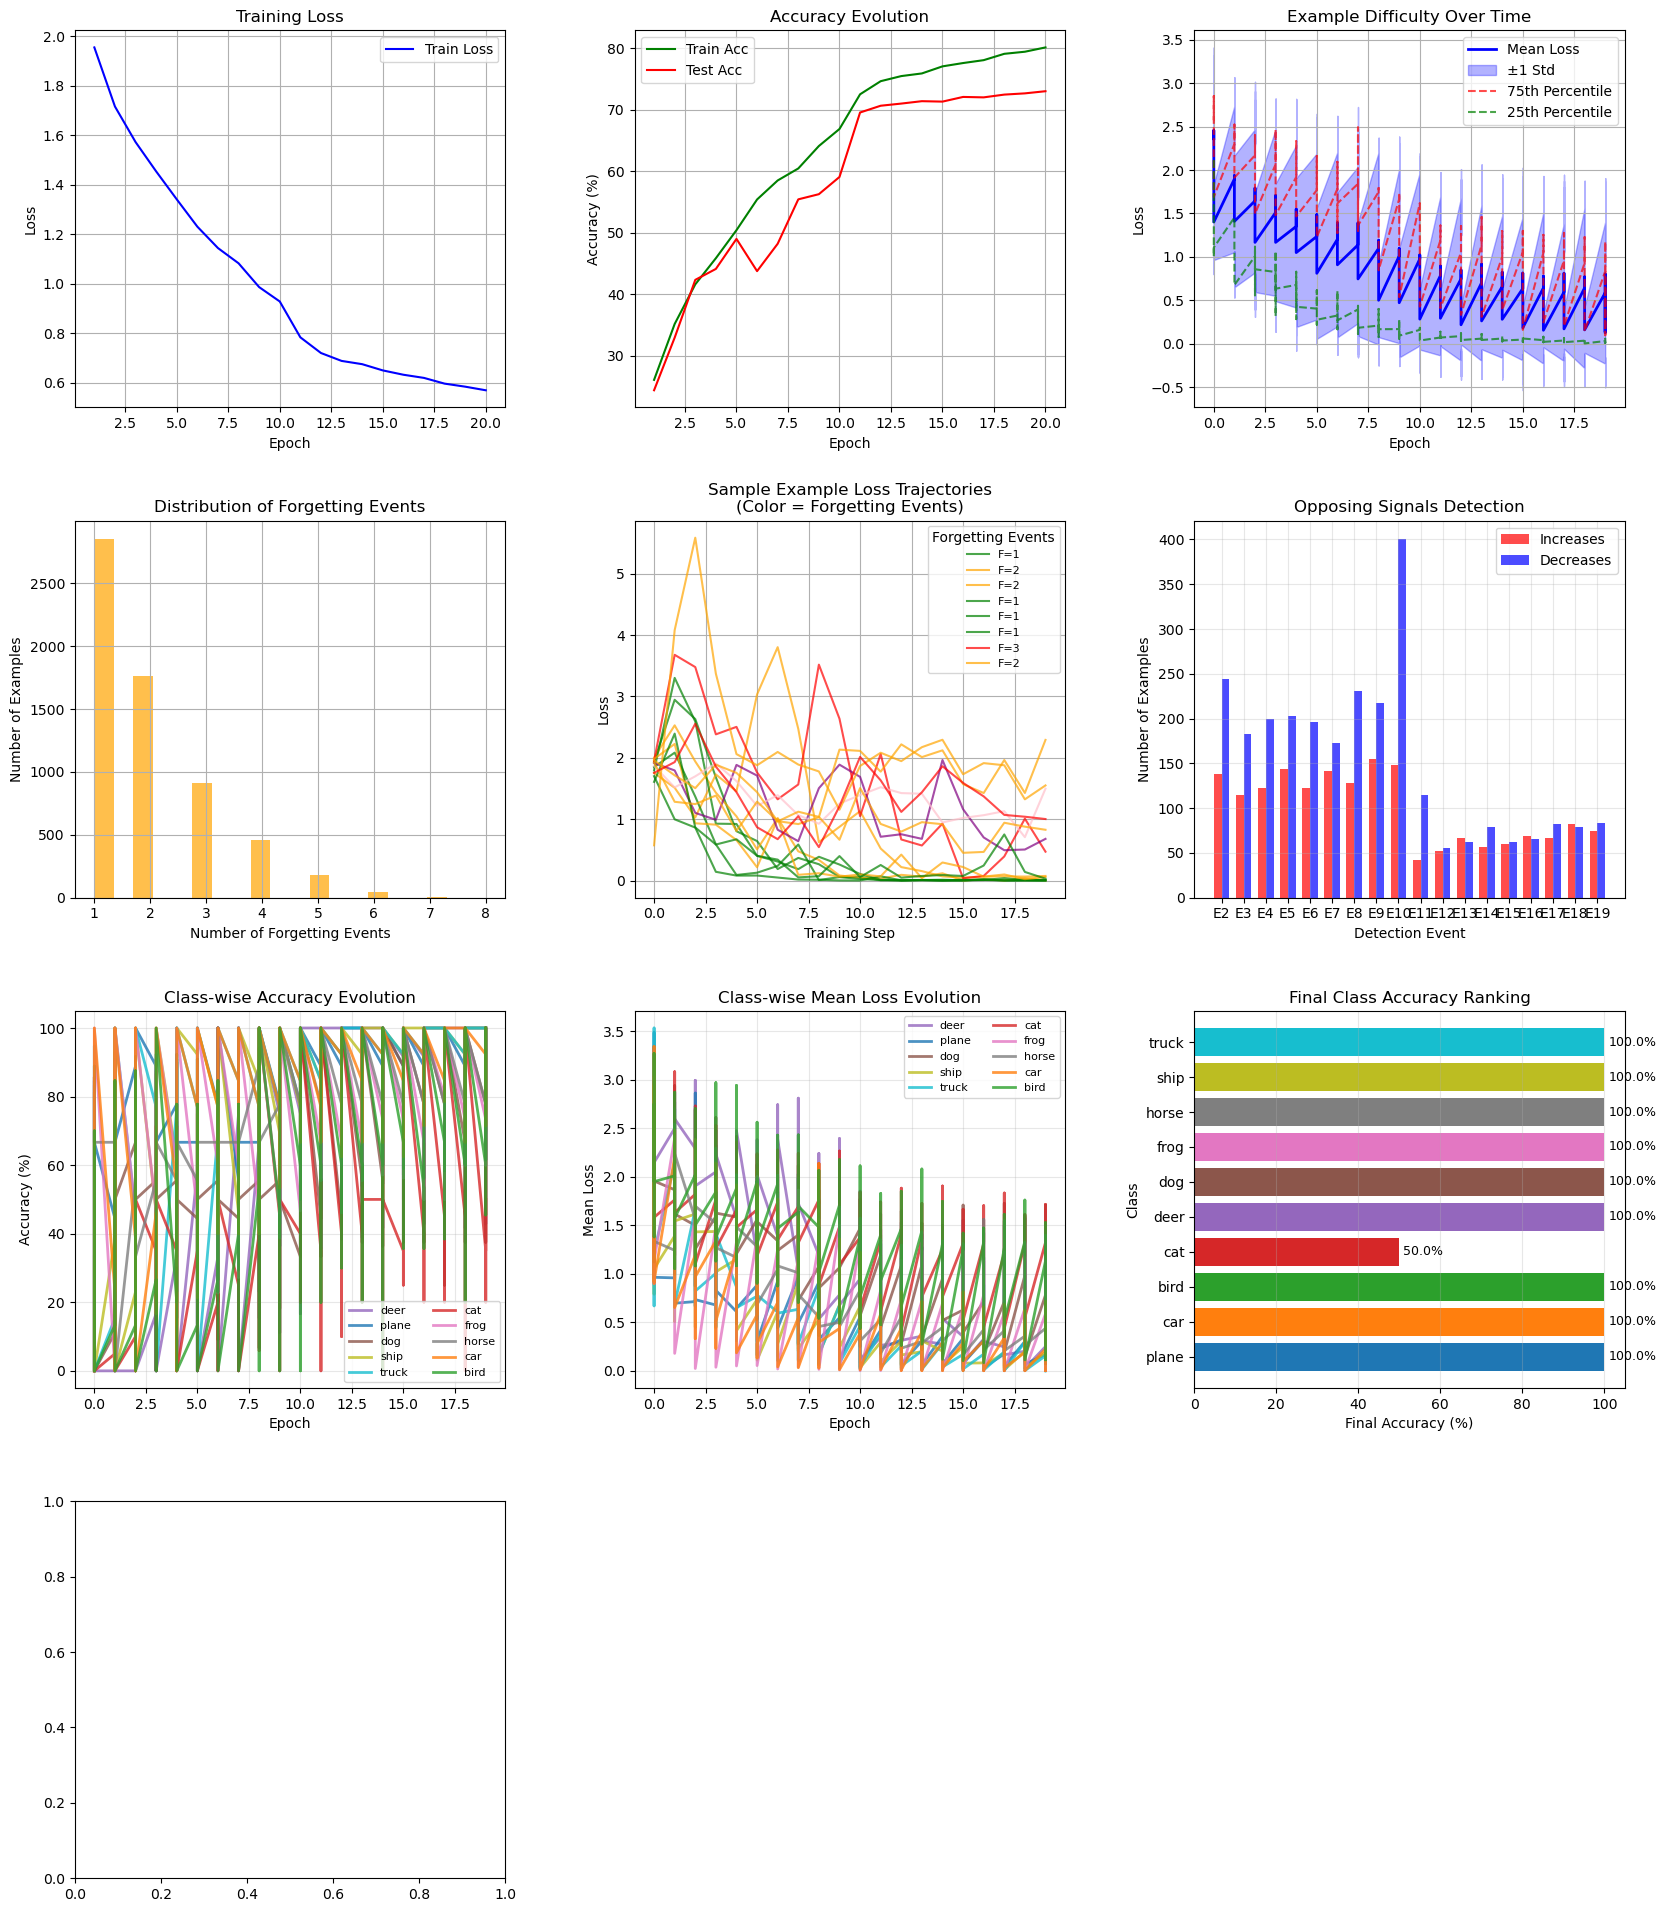

In [7]:
# Create comprehensive enhanced visualizations
fig = plt.figure(figsize=(20, 24))

# Create a 4x3 grid of subplots
gs = fig.add_gridspec(4, 3, height_ratios=[1, 1, 1, 1], hspace=0.3, wspace=0.3)

# 1. Training curves
ax1 = fig.add_subplot(gs[0, 0])
epochs_range = range(1, len(results['train_losses']) + 1)
ax1.plot(epochs_range, results['train_losses'], 'b-', label='Train Loss')
ax1.set_title('Training Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True)

# 2. Accuracy curves
ax2 = fig.add_subplot(gs[0, 1])
ax2.plot(epochs_range, results['train_accuracies'], 'g-', label='Train Acc')
ax2.plot(epochs_range, results['test_accuracies'], 'r-', label='Test Acc')
ax2.set_title('Accuracy Evolution')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.legend()
ax2.grid(True)

# 3. ENHANCED: Example Difficulty Over Time
ax3 = fig.add_subplot(gs[0, 2])
if tracker.epoch_stats:
    epochs_data = [s['epoch'] for s in tracker.epoch_stats]
    mean_losses = [s['mean_loss'] for s in tracker.epoch_stats]
    std_losses = [s['std_loss'] for s in tracker.epoch_stats]
    q75_losses = [s['q75_loss'] for s in tracker.epoch_stats]
    q25_losses = [s['q25_loss'] for s in tracker.epoch_stats]
    
    ax3.plot(epochs_data, mean_losses, 'b-', linewidth=2, label='Mean Loss')
    ax3.fill_between(epochs_data, 
                   [m - s for m, s in zip(mean_losses, std_losses)],
                   [m + s for m, s in zip(mean_losses, std_losses)],
                   alpha=0.3, color='blue', label='±1 Std')
    ax3.plot(epochs_data, q75_losses, 'r--', alpha=0.7, label='75th Percentile')
    ax3.plot(epochs_data, q25_losses, 'g--', alpha=0.7, label='25th Percentile')
ax3.set_title('Example Difficulty Over Time')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Loss')
ax3.legend()
ax3.grid(True)

# 4. Forgetting events distribution
ax4 = fig.add_subplot(gs[1, 0])
forgetting_counts = list(tracker.forgetting_events.values())
ax4.hist(forgetting_counts, bins=20, alpha=0.7, color='orange')
ax4.set_title('Distribution of Forgetting Events')
ax4.set_xlabel('Number of Forgetting Events')
ax4.set_ylabel('Number of Examples')
ax4.grid(True)

# 5. ENHANCED: Sample Example Loss Trajectories (30+ examples with color coding)
ax5 = fig.add_subplot(gs[1, 1])
forgettable = tracker.get_forgettable_examples(min_forgetting=1)
unforgettable = tracker.get_unforgettable_examples()

# Sample more examples
sample_examples = []
if len(forgettable) > 0:
    sample_examples.extend(list(forgettable.keys())[:15])
if len(unforgettable) > 0:
    sample_examples.extend(list(unforgettable.keys())[:15])

# Create color map based on forgetting events
colors = ['blue', 'green', 'orange', 'red', 'purple', 'brown', 'pink', 'gray']

plotted_examples = 0
for example_id in sample_examples[:30]:  # Limit to 30 for readability
    if example_id in tracker.example_losses:
        losses = tracker.example_losses[example_id]
        forgetting_count = tracker.forgetting_events[example_id]
        color_idx = min(forgetting_count, len(colors) - 1)
        
        ax5.plot(range(len(losses)), losses, color=colors[color_idx], 
               alpha=0.7, linewidth=1.5, 
               label=f'F={forgetting_count}' if plotted_examples < 8 else '')
        plotted_examples += 1

ax5.set_title('Sample Example Loss Trajectories\n(Color = Forgetting Events)')
ax5.set_xlabel('Training Step')
ax5.set_ylabel('Loss')
ax5.legend(fontsize=8, title='Forgetting Events')
ax5.grid(True)

# 6. Opposing signals
ax6 = fig.add_subplot(gs[1, 2])
if tracker.opposing_signals:
    signal_epochs = [s['epoch'] for s in tracker.opposing_signals]
    increases = [len(s['increases']) for s in tracker.opposing_signals]
    decreases = [len(s['decreases']) for s in tracker.opposing_signals]
    
    x = np.arange(len(signal_epochs))
    width = 0.35
    
    ax6.bar(x - width/2, increases, width, label='Increases', alpha=0.7, color='red')
    ax6.bar(x + width/2, decreases, width, label='Decreases', alpha=0.7, color='blue')
    ax6.set_xlabel('Detection Event')
    ax6.set_ylabel('Number of Examples')
    ax6.set_title('Opposing Signals Detection')
    ax6.set_xticks(x)
    ax6.set_xticklabels([f'E{e}' for e in signal_epochs])
    ax6.legend()
    ax6.grid(True, alpha=0.3)
else:
    ax6.text(0.5, 0.5, 'No opposing signals\ndetected', ha='center', va='center', 
           transform=ax6.transAxes, fontsize=12)
    ax6.set_title('Opposing Signals Detection')

# 7. ENHANCED: Class-wise Accuracy Evolution
ax7 = fig.add_subplot(gs[2, 0])
class_analysis = tracker.get_class_analysis()
class_colors = plt.cm.tab10(np.linspace(0, 1, 10))

for class_id, stats in tracker.class_stats.items():
    if stats['accuracy'] and class_id < 10:
        epochs_data = stats['epoch']
        accuracy_data = [acc * 100 for acc in stats['accuracy']]  # Convert to percentage
        ax7.plot(epochs_data, accuracy_data, color=class_colors[class_id], 
               linewidth=2, label=f'{classes[class_id]}', alpha=0.8)

ax7.set_title('Class-wise Accuracy Evolution')
ax7.set_xlabel('Epoch')
ax7.set_ylabel('Accuracy (%)')
ax7.legend(fontsize=8, ncol=2)
ax7.grid(True, alpha=0.3)

# 8. ENHANCED: Class-wise Loss Evolution
ax8 = fig.add_subplot(gs[2, 1])
for class_id, stats in tracker.class_stats.items():
    if stats['mean_loss'] and class_id < 10:
        epochs_data = stats['epoch']
        loss_data = stats['mean_loss']
        ax8.plot(epochs_data, loss_data, color=class_colors[class_id], 
               linewidth=2, label=f'{classes[class_id]}', alpha=0.8)

ax8.set_title('Class-wise Mean Loss Evolution')
ax8.set_xlabel('Epoch')
ax8.set_ylabel('Mean Loss')
ax8.legend(fontsize=8, ncol=2)
ax8.grid(True, alpha=0.3)

# 9. ENHANCED: Class Difficulty Ranking
ax9 = fig.add_subplot(gs[2, 2])
if class_analysis:
    class_names = [classes[cid] for cid in sorted(class_analysis.keys()) if cid < 10]
    final_accuracies = [class_analysis[cid]['final_accuracy'] * 100 
                       for cid in sorted(class_analysis.keys()) if cid < 10]
    
    bars = ax9.barh(class_names, final_accuracies, color=class_colors[:len(class_names)])
    ax9.set_title('Final Class Accuracy Ranking')
    ax9.set_xlabel('Final Accuracy (%)')
    ax9.set_ylabel('Class')
    
    # Add value labels on bars
    for bar, acc in zip(bars, final_accuracies):
        ax9.text(bar.get_width() + 1, bar.get_y() + bar.get_height()/2, 
               f'{acc:.1f}%', va='center', fontsize=9)

ax9.grid(True, axis='x', alpha=0.3)

# 10. Learning vs Forgetting events
ax10 = fig.add_subplot(gs[3, 0])
learning_counts = list(tracker.learning_events.values())
ax10.scatter(forgetting_counts, learning_counts, alpha=0.6, s=50)
ax10.set_title('Learning vs Forgetting Events')
ax10.set_xlabel('Forgetting Events')
ax10.set_ylabel('Learning Events')
ax10.grid(True)

# 11. ENHANCED: Time-based Clustering Visualization
ax11 = fig.add_subplot(gs[3, 1])
clustered_examples = tracker.cluster_examples_by_time(n_clusters=5)
if clustered_examples:
    cluster_colors = ['red', 'blue', 'green', 'orange', 'purple']
    cluster_labels = ['Early Learners', 'Late Learners', 'Stable', 'Volatile', 'Difficult']
    
    for i, (cluster_id, example_ids) in enumerate(clustered_examples.items()):
        # Sample a few examples from each cluster
        sample_ids = example_ids[:5]
        for example_id in sample_ids:
            if example_id in tracker.example_losses:
                losses = tracker.example_losses[example_id]
                ax11.plot(range(len(losses)), losses, 
                        color=cluster_colors[i % len(cluster_colors)], 
                        alpha=0.6, linewidth=1)
    
    # Create legend
    for i in range(min(len(clustered_examples), len(cluster_colors))):
        ax11.plot([], [], color=cluster_colors[i], linewidth=3, 
                label=f'Cluster {i}: {cluster_labels[i]}')
    
    ax11.set_title('Time-based Example Clustering')
    ax11.set_xlabel('Training Step')
    ax11.set_ylabel('Loss')
    ax11.legend(fontsize=8)
    ax11.grid(True)
else:
    ax11.text(0.5, 0.5, 'Not enough data\nfor clustering', ha='center', va='center', 
            transform=ax11.transAxes, fontsize=12)
    ax11.set_title('Time-based Example Clustering')

# 12. ENHANCED: Final Summary Statistics
ax12 = fig.add_subplot(gs[3, 2])
ax12.axis('off')

# Create summary text
analysis = tracker.analyze_learning_patterns()
class_analysis = tracker.get_class_analysis()

summary_text = f"""ENHANCED ANALYSIS SUMMARY
{'=' * 25}

Dataset Statistics:
• Total Examples: {analysis['total_examples']:,}
• Forgettable: {analysis['forgettable_examples']:,} ({100*analysis['forgettable_examples']/analysis['total_examples']:.1f}%)
• Unforgettable: {analysis['unforgettable_examples']:,} ({100*analysis['unforgettable_examples']/analysis['total_examples']:.1f}%)

Learning Dynamics:
• Opposing Signals: {analysis['opposing_signals_detected']}
• Avg Forgetting Events: {analysis['avg_forgetting_events']:.2f}
• Avg Learning Events: {analysis['avg_learning_events']:.2f}

Class Performance:
{'• ' + chr(10).join([f'{classes[cid]}: {stats["final_accuracy"]*100:.1f}%' for cid, stats in sorted(class_analysis.items())[:5] if cid < 10]) if class_analysis else '• No class data available'}

Model Performance:
• Final Train Acc: {results['train_accuracies'][-1]:.2f}%
• Final Test Acc: {results['test_accuracies'][-1]:.2f}%
• Generalization Gap: {results['train_accuracies'][-1] - results['test_accuracies'][-1]:.2f}%"""

ax12.text(0.05, 0.95, summary_text, transform=ax12.transAxes, fontsize=10, 
        verticalalignment='top', fontfamily='monospace',
        bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.8))

plt.suptitle('Enhanced Neural Network Training Dynamics Analysis', fontsize=16, y=0.98)
plt.tight_layout()
plt.show()

## 7. Time-based Detailed Analysis

Enhanced analysis of examples grouped by their learning time patterns.

In [ ]:
def analyze_time_based_patterns(tracker, trainset_subset, n_examples=20):
    """Detailed analysis of examples grouped by time-based learning patterns"""
    
    # Get clustered examples
    clustered_examples = tracker.cluster_examples_by_time(n_clusters=4)
    
    if not clustered_examples:
        print("Not enough data for time-based clustering analysis")
        return
    
    cluster_names = ['Early Learners', 'Late Learners', 'Volatile Learners', 'Difficult Examples']
    
    fig, axes = plt.subplots(2, 2, figsize=(20, 16))
    axes = axes.flatten()
    
    for cluster_idx, (cluster_id, example_ids) in enumerate(clustered_examples.items()):
        if cluster_idx >= 4:  # Limit to 4 clusters for display
            break
            
        ax = axes[cluster_idx]
        
        # Sample examples from this cluster
        sample_ids = example_ids[:min(n_examples // 4, len(example_ids))]
        
        print(f"\n{cluster_names[cluster_idx]} (Cluster {cluster_id}):")
        print(f"Total examples in cluster: {len(example_ids)}")
        
        cluster_forgetting_events = []
        cluster_final_losses = []
        cluster_volatilities = []
        
        for i, example_id in enumerate(sample_ids):
            if example_id in tracker.example_losses:
                losses = tracker.example_losses[example_id]
                correctness = tracker.example_correctness[example_id]
                forgetting_count = tracker.forgetting_events[example_id]
                
                # Calculate statistics
                volatility = np.std(np.diff(losses)) if len(losses) > 1 else 0
                final_loss = losses[-1] if losses else float('inf')
                final_correct = correctness[-1] if correctness else False
                
                cluster_forgetting_events.append(forgetting_count)
                cluster_final_losses.append(final_loss)
                cluster_volatilities.append(volatility)
                
                # Plot loss trajectory
                color = 'green' if final_correct else 'red'
                ax.plot(range(len(losses)), losses, color=color, alpha=0.7, linewidth=1.5)
                
                # Get actual image and class for first few examples
                if i < 3:
                    try:
                        if hasattr(trainset_subset, 'dataset'):  # Subset
                            actual_idx = trainset_subset.indices[example_id] if example_id < len(trainset_subset.indices) else 0
                            image, label = trainset_subset.dataset[actual_idx]
                        else:
                            image, label = trainset_subset[example_id] if example_id < len(trainset_subset) else trainset_subset[0]
                        
                        print(f"  Example {example_id}: {classes[label]}, Forgetting: {forgetting_count}, "
                              f"Final Loss: {final_loss:.3f}, Volatility: {volatility:.3f}")
                    except:
                        print(f"  Example {example_id}: Forgetting: {forgetting_count}, "
                              f"Final Loss: {final_loss:.3f}, Volatility: {volatility:.3f}")
        
        ax.set_title(f"{cluster_names[cluster_idx]}\n"
                   f"Avg Forgetting: {np.mean(cluster_forgetting_events):.2f}, "
                   f"Avg Volatility: {np.mean(cluster_volatilities):.3f}")
        ax.set_xlabel('Training Step')
        ax.set_ylabel('Loss')
        ax.grid(True, alpha=0.3)
        
        # Add legend
        ax.plot([], [], color='green', linewidth=2, label='Final: Correct')
        ax.plot([], [], color='red', linewidth=2, label='Final: Incorrect')
        ax.legend()
        
        print(f"Cluster statistics:")
        print(f"  - Mean forgetting events: {np.mean(cluster_forgetting_events):.2f}")
        print(f"  - Mean final loss: {np.mean(cluster_final_losses):.3f}")
        print(f"  - Mean volatility: {np.mean(cluster_volatilities):.3f}")
        print(f"  - Examples analyzed: {len(sample_ids)}")
    
    plt.tight_layout()
    plt.suptitle('Time-based Example Clustering: Detailed Analysis', fontsize=16, y=1.02)
    plt.show()

# Run the enhanced time-based analysis
analyze_time_based_patterns(tracker, trainset_subset)

## 8. Enhanced Summary and Export

Generate comprehensive summary with all enhancements.

In [ ]:
def generate_enhanced_summary_report(tracker, results):
    """Generate comprehensive enhanced summary report"""
    
    print("=" * 70)
    print("         ENHANCED TRAINING DYNAMICS ANALYSIS REPORT")
    print("=" * 70)
    
    # Basic training performance
    final_train_acc = results['train_accuracies'][-1]
    final_test_acc = results['test_accuracies'][-1]
    print(f"Model Performance:")
    print(f"  Final Training Accuracy: {final_train_acc:.2f}%")
    print(f"  Final Test Accuracy: {final_test_acc:.2f}%")
    print(f"  Generalization Gap: {final_train_acc - final_test_acc:.2f}%")
    
    # Enhanced example analysis
    analysis = tracker.analyze_learning_patterns()
    total_examples = analysis['total_examples']
    forgettable = analysis['forgettable_examples']
    unforgettable = analysis['unforgettable_examples']
    
    print(f"\nEnhanced Example Learning Patterns:")
    print(f"  Total Examples Tracked: {total_examples:,}")
    print(f"  Forgettable Examples: {forgettable:,} ({100*forgettable/total_examples:.1f}%)")
    print(f"  Unforgettable Examples: {unforgettable:,} ({100*unforgettable/total_examples:.1f}%)")
    print(f"  Average Forgetting Events per Example: {analysis['avg_forgetting_events']:.2f}")
    print(f"  Average Learning Events per Example: {analysis['avg_learning_events']:.2f}")
    
    # Enhanced opposing signals analysis
    opposing_signals = len(tracker.opposing_signals)
    print(f"\nEnhanced Opposing Signals Analysis (Threshold: 1.5):")
    print(f"  Total Opposing Signal Events Detected: {opposing_signals}")
    
    if opposing_signals > 0:
        total_increases = sum(len(s['increases']) for s in tracker.opposing_signals)
        total_decreases = sum(len(s['decreases']) for s in tracker.opposing_signals)
        print(f"  Total Examples with Large Loss Increases: {total_increases}")
        print(f"  Total Examples with Large Loss Decreases: {total_decreases}")
        
        epoch_counts = {}
        for s in tracker.opposing_signals:
            epoch = s['epoch']
            count = len(s['increases']) + len(s['decreases'])
            epoch_counts[epoch] = count
        
        max_epoch = max(epoch_counts, key=epoch_counts.get)
        print(f"  Epoch with Most Opposing Signals: {max_epoch} ({epoch_counts[max_epoch]} examples)")
    
    # NEW: Class-wise analysis
    class_analysis = tracker.get_class_analysis()
    if class_analysis:
        print(f"\nClass-wise Performance Analysis:")
        
        # Sort classes by final accuracy
        sorted_classes = sorted(class_analysis.items(), 
                              key=lambda x: x[1]['final_accuracy'], reverse=True)
        
        print(f"  Easiest Classes (Highest Final Accuracy):")
        for i, (class_id, stats) in enumerate(sorted_classes[:3]):
            if class_id < 10:
                print(f"    {i+1}. {classes[class_id]}: {stats['final_accuracy']*100:.1f}% "
                      f"(Improvement: {stats['accuracy_improvement']*100:.1f}%)")
        
        print(f"  Hardest Classes (Lowest Final Accuracy):")
        for i, (class_id, stats) in enumerate(sorted_classes[-3:]):
            if class_id < 10:
                print(f"    {len(sorted_classes)-2+i}. {classes[class_id]}: {stats['final_accuracy']*100:.1f}% "
                      f"(Improvement: {stats['accuracy_improvement']*100:.1f}%)")
    
    # NEW: Time-based clustering results
    clustered_examples = tracker.cluster_examples_by_time(n_clusters=5)
    if clustered_examples:
        print(f"\nTime-based Learning Pattern Clusters:")
        cluster_names = ['Early Learners', 'Late Learners', 'Stable', 'Volatile', 'Difficult']
        
        for i, (cluster_id, example_ids) in enumerate(clustered_examples.items()):
            cluster_name = cluster_names[i] if i < len(cluster_names) else f'Cluster {cluster_id}'
            print(f"  {cluster_name}: {len(example_ids)} examples")
    
    # Enhanced difficulty analysis
    if tracker.epoch_stats:
        initial_difficulty = tracker.epoch_stats[0]['mean_loss']
        final_difficulty = tracker.epoch_stats[-1]['mean_loss']
        max_difficulty = max(s['mean_loss'] for s in tracker.epoch_stats)
        min_difficulty = min(s['mean_loss'] for s in tracker.epoch_stats)
        
        print(f"\nExample Difficulty Progression:")
        print(f"  Initial Mean Difficulty: {initial_difficulty:.3f}")
        print(f"  Final Mean Difficulty: {final_difficulty:.3f}")
        print(f"  Difficulty Reduction: {((initial_difficulty - final_difficulty) / initial_difficulty * 100):.1f}%")
        print(f"  Peak Difficulty: {max_difficulty:.3f}")
        print(f"  Lowest Difficulty: {min_difficulty:.3f}")
    
    print("\n" + "=" * 70)
    print("ENHANCED KEY INSIGHTS:")
    print("=" * 70)
    
    insights = []
    
    if forgettable / total_examples > 0.1:
        insights.append(f"• High forgetting rate ({100*forgettable/total_examples:.1f}%) detected with enhanced tracking")
    
    if opposing_signals > 0:
        insights.append(f"• {opposing_signals} opposing signal events detected with enhanced sensitivity (threshold 1.5)")
    
    if class_analysis:
        class_range = max(s['final_accuracy'] for s in class_analysis.values()) - min(s['final_accuracy'] for s in class_analysis.values())
        insights.append(f"• Class difficulty varies by {class_range*100:.1f}% in final accuracy")
    
    if clustered_examples:
        insights.append(f"• {len(clustered_examples)} distinct learning pattern clusters identified")
    
    if final_train_acc - final_test_acc > 5:
        insights.append(f"• Large generalization gap ({final_train_acc - final_test_acc:.1f}%) indicates overfitting")
    
    if analysis['avg_forgetting_events'] > 1:
        insights.append(f"• High average forgetting events ({analysis['avg_forgetting_events']:.2f}) suggests dataset complexity")
    
    for insight in insights:
        print(insight)
    
    if not insights:
        insights.append("• Training proceeded smoothly with enhanced monitoring showing stable dynamics")
    
    print(f"\nENHANCED RECOMMENDATIONS:")
    print("• Use time-based clustering for curriculum learning design")
    print("• Examine forgettable examples for data quality issues")
    print("• Focus training resources on hardest-to-learn classes")
    print("• Use class-wise analysis for balanced training strategies")
    print("• Monitor opposing signals as early training instability indicators")
    print("• Leverage example difficulty progression for adaptive learning rates")
    
    print("\n" + "=" * 70)

# Generate enhanced final report
generate_enhanced_summary_report(tracker, results)

# Export enhanced data
def export_enhanced_data(tracker, results, filename_prefix='enhanced_training_dynamics'):
    """Export all enhanced tracking data"""
    
    # 1. Enhanced example statistics
    example_stats = []
    for example_id in tracker.example_losses.keys():
        losses = tracker.example_losses[example_id]
        correctness = tracker.example_correctness[example_id]
        
        volatility = np.std(np.diff(losses)) if len(losses) > 1 else 0
        first_correct_epoch = next((i for i, correct in enumerate(correctness) if correct), len(correctness))
        final_accuracy = np.mean(correctness[-5:]) if len(correctness) >= 5 else np.mean(correctness)
        
        stats = {
            'example_id': example_id,
            'class_label': tracker.class_labels[example_id] if example_id < len(tracker.class_labels) else -1,
            'total_forgetting_events': tracker.forgetting_events.get(example_id, 0),
            'total_learning_events': tracker.learning_events.get(example_id, 0),
            'final_loss': losses[-1] if losses else None,
            'mean_loss': np.mean(losses) if losses else None,
            'loss_volatility': volatility,
            'first_correct_epoch': first_correct_epoch,
            'final_accuracy': final_accuracy,
            'final_correct': correctness[-1] if correctness else None
        }
        example_stats.append(stats)
    
    example_df = pd.DataFrame(example_stats)
    example_df.to_csv(f'{filename_prefix}_example_statistics.csv', index=False)
    
    # 2. Class-wise analysis
    class_analysis = tracker.get_class_analysis()
    if class_analysis:
        class_df = pd.DataFrame.from_dict(class_analysis, orient='index')
        class_df.index.name = 'class_id'
        class_df.to_csv(f'{filename_prefix}_class_analysis.csv')
    
    # 3. Enhanced epoch statistics
    if tracker.epoch_stats:
        epoch_df = pd.DataFrame(tracker.epoch_stats)
        epoch_df.to_csv(f'{filename_prefix}_epoch_statistics.csv', index=False)
    
    # 4. Opposing signals with enhanced data
    if tracker.opposing_signals:
        signals_data = []
        for signal in tracker.opposing_signals:
            signals_data.append({
                'epoch': signal['epoch'],
                'num_increases': len(signal['increases']),
                'num_decreases': len(signal['decreases']),
                'total_affected': len(signal['increases']) + len(signal['decreases'])
            })
        signals_df = pd.DataFrame(signals_data)
        signals_df.to_csv(f'{filename_prefix}_opposing_signals.csv', index=False)
    
    print(f"Enhanced data exported with prefix: {filename_prefix}_")
    print("Files created:")
    print("- example_statistics.csv (with volatility, clustering features)")
    print("- class_analysis.csv (per-class performance metrics)")
    print("- epoch_statistics.csv (difficulty progression over time)")
    print("- opposing_signals.csv (enhanced signal detection data)")

# Export enhanced data
export_enhanced_data(tracker, results)